<a href="https://colab.research.google.com/github/francescomazzolin/stochastic-finance-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stochastic Finance Project

Giada Martini

Francesco Mazzolin

Francesco Salvagnin

Nicolas Stecca


## Importing the packages


In [136]:

#!pip install eikon

import eikon as ek
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve
import analytical_functions as af


## Retrieving the data

In [2]:
# Setting up the API key
ek.set_app_key('6e2b6a629eb84c0b859dc5faf22d48f94d85de97')

#### Search parameters


In [29]:

fields = ['TR.CLOSEPRICE.date',
            'TR.CLOSEPRICE', 
            'TR.F.ShrUsedToCalcDilEPSTot','TR.F.MktCap', 'TR.F.DebtTot']

start_date = '2024-12-30'

end_date = '2018-12-30'

In [62]:
#Setting up the function
def get_financial_data(rics, fields, 
                       start_date, end_date):
    rics = rics
    #Data fields we are interested in: 
      #Total value of equity
      #Total value of debt

    results = []

    df = pd.DataFrame()

    for ric in rics:
        data, err = ek.get_data([ric], fields,
                                {'SDate': f'{start_date}' , 'EDate': f'{end_date}', 'FRQ':'D','period':'FY0'}) #Not sure about period
        if err is None:
            data['RIC'] = ric
            results.append(data)
        else:
            print(f"Error retrieving data for {ric}: {err}")
        
        #Computing the log-returns
        prices = data.loc[ric]['Close Price']
        log_returns = np.log(prices / prices.shift(1)).dropna()
        data['Log_Returns'] = log_returns
        data.dropna()

        #Compute the rolling-window estimation of the volatility using last year observations
        data['Rolling_Volatility'] = data['Log_Returns'].rolling(window=252).std()
        
        data = data.dropna(subset=['Rolling_Volatility'])


        #Computing total asset values as a sum of the market capitalization + total debt
        #data['Total_value'] = data['Market Capitalization'] + data['Debt - Total']
        data['Total_value'] = (data['Close Price'] * data['Shares used to calculate Diluted EPS - Total']) + data['Debt - Total']
        
        
        data = data.set_index(['Instrument', 'Date'])

    #Combine results into a single DataFrame
        df = pd.concat([df, data])
    #df.drop(columns=['RIC'])

    #Add Total asset value column
    

    return df


#### Choosing the stocks

In [12]:
rics_list = ['AAPL.O', 'META.O']

#### Retrieving the data

In [68]:
data = get_financial_data(rics_list, fields,
                          start_date, end_date)

c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [125]:
import pickle
import sys
import os

current_directory = os.getcwd()

# Add the current working directory to sys.path
if current_directory not in sys.path:
    sys.path.append(current_directory)
    print('Yes')


with open('dataframe.pkl', mode= 'rb') as f:

    data = pickle.load(f)

In [115]:
#Checks on single stocks
print(data.loc['AAPL.O'].head())

                      Close Price  \
Date                                
2024-12-30T00:00:00Z        252.2   
2024-12-27T00:00:00Z       255.59   
2024-12-26T00:00:00Z       259.02   
2024-12-24T00:00:00Z        258.2   
2024-12-23T00:00:00Z       255.27   

                      Shares used to calculate Diluted EPS - Total  \
Date                                                                 
2024-12-30T00:00:00Z                                   15408095000   
2024-12-27T00:00:00Z                                   15408095000   
2024-12-26T00:00:00Z                                   15408095000   
2024-12-24T00:00:00Z                                   15408095000   
2024-12-23T00:00:00Z                                   15408095000   

                      Market Capitalization    Debt - Total     RIC  \
Date                                                                  
2024-12-30T00:00:00Z        3463350367230.0  107525000000.0  AAPL.O   
2024-12-27T00:00:00Z        34633503

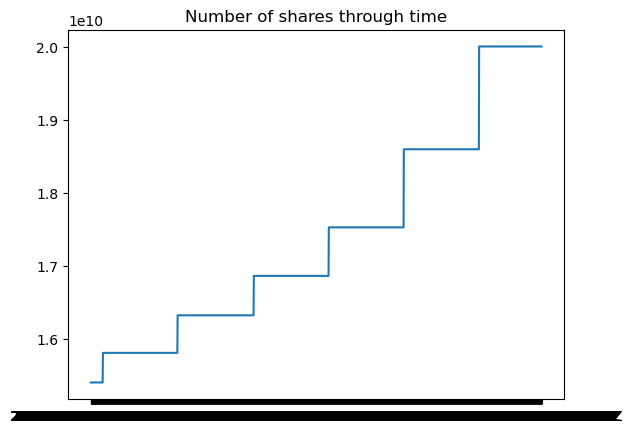

In [120]:
#Plot of outstanding shares 
import matplotlib.pyplot as plt

plt.figure()

plt.title('Number of shares through time')

plt.plot(data.loc['AAPL.O']['Shares used to calculate Diluted EPS - Total'])

plt.show()


## Computing the value of the asset and its volatility

In [126]:
df_k = pd.DataFrame()

for ric in rics_list:
    df = data.loc[ric]
    df = df.reset_index()
    df['Total_value'] = (df['Close Price'] * df['Shares used to calculate Diluted EPS - Total']) +df['Debt - Total']
    # Compute log returns and rolling volatility
    df['Log_Returns'] = np.log(df['Close Price'] / df['Close Price'].shift(1))
    df['Rolling_Volatility'] = df['Log_Returns'].rolling(window=252).std() 
    df = df.dropna(subset=['Rolling_Volatility'])
    
    # Compute total asset value (equity + debt)
    #df['Total_value'] = df['Market Capitalization'] + df['Debt - Total']
    df['RIC'] = ric
    df = df.set_index([f'RIC', 'Date'])
    df = df.dropna(how='any')

    # Drop rows with missing data
    

    df_k = pd.concat([df, df_k])

data = df_k.copy()

In [134]:
data.loc[rics_list[1]].describe()

,Close Price,Shares used to calculate Diluted EPS - Total,Market Capitalization,Debt - Total,Total_value,Log_Returns,Rolling_Volatility
count,1258.0,1258.0,1258.0,1258.0,1258.0,1258.0,1258.000000
mean,236.277965,2853156597.774245,599550784484.942017,2248071542.130366,675233909300.476929,-0.000704,0.027582
std,68.702365,74316327.864756,234030740089.511688,3951993284.117497,193744793944.495026,0.027813,0.006818
min,88.91,2702000000.0,315555188424.080017,0.0,254774690000.0,-0.209307,0.016014
25%,182.5825,2859000000.0,376724818057.080017,473000000.0,528494495000.0,-0.014181,0.022379
50%,219.665,2876000000.0,585320975487.75,523000000.0,634899010000.0,-0.001025,0.025531
75%,296.6775,2888000000.0,778039626010.359985,581000000.0,825391345000.0,0.011486,0.033254
max,382.18,2925000000.0,935644813206.599976,10610000000.0,1104258840000.0,0.306391,0.044416


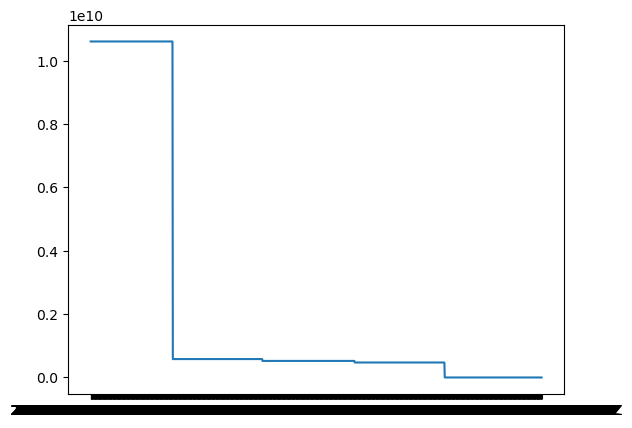

In [135]:
plt.figure()

plt.plot(data.loc[rics_list[1]]['Debt - Total'])
plt.show()

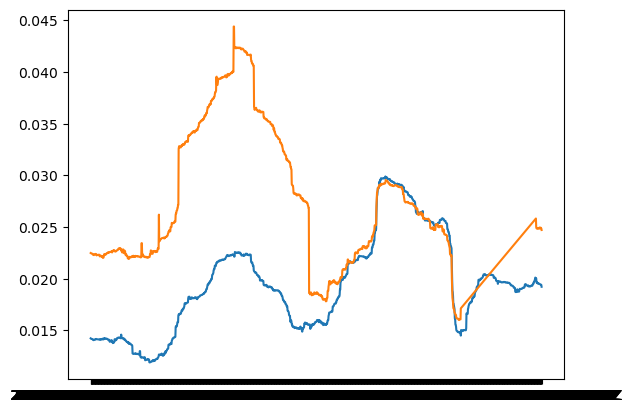

In [131]:
for ric in rics_list:

    plt.plot(data.loc[ric]['Rolling_Volatility'])

In [118]:
data.shape

(2766, 7)

In [128]:
# Solve the system for each row
def solve_system(row):
    # Extract parameters from the row
    E = row['Close Price'] * row['Shares used to calculate Diluted EPS - Total'] # Equity (market capitalization)
    sigma_E = row['Rolling_Volatility']*252  # Rolling volatility as initial guess for sigma_A
    D = row['Debt - Total']          # Debt
    
    row['Risk_Free_Rate'] = 0.04
    r = row['Risk_Free_Rate']        # Assume a risk-free rate column
    
    T = 1                            # Time to maturity (1 year)
    t = 0                            # Current time

    # Define the system of equations
    def system(vars):
        A, sigma_A = vars  # Unknowns: Asset value and asset volatility
        equity_value = af.merton_equity(A, D, r, sigma_A, T, t)
        d1 = (np.log(A / D) + (r + 0.5 * sigma_A**2) * (T - t)) / (sigma_A * np.sqrt(T - t))
        f1 = equity_value - E  # Equation (2)
        f2 = (A / E) * norm.cdf(d1) * sigma_A - sigma_E  # Equation (4)
        return [f1, f2]

    # Initial guesses
    A_guess = row['Total_value']  # Total value (equity + debt)
    sigma_A_guess = row['Rolling_Volatility'] *252  # Rolling volatility

    # Solve the system
    solution = fsolve(system, [A_guess, sigma_A_guess])
    return pd.Series({'A_solution': solution[0], 'sigma_A_solution': solution[1]})

# Apply the solver to the DataFrame
def solve_for_all(df):
    results = df.apply(solve_system, axis=1)
    return pd.concat([df, results], axis=1)


In [129]:
df_with_solutions = solve_for_all(data)

c:\Users\franc\OneDrive\Synced Desktop\SF_project\codes\stochastic-finance-project\analytical_functions.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(V/K) + (r + 0.5*sigma**2)*(T-t))/ (sigma * np.sqrt(T-t))
C:\Users\franc\AppData\Local\Temp\ipykernel_10856\128518355.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(A / D) + (r + 0.5 * sigma_A**2) * (T - t)) / (sigma_A * np.sqrt(T - t))
c:\Users\franc\OneDrive\Synced Desktop\SF_project\codes\stochastic-finance-project\analytical_functions.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(V/K) + (r + 0.5*sigma**2)*(T-t))/ (sigma * np.sqrt(T-t))
C:\Users\franc\AppData\Local\Temp\ipykernel_10856\128518355.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(A / D) + (r + 0.5 * sigma_A**2) * (T - t)) / (sigma_A * np.sqrt(T - t))
c:\Users\franc\OneDrive\Synced Desktop\SF_project\codes\stochastic-finance-project\analy

In [122]:
df_with_solutions

Close Price  \
RIC    Date                                
META.O 2023-12-28T00:00:00Z       358.32   
       2023-12-27T00:00:00Z       357.83   
       2023-12-26T00:00:00Z       354.83   
       2023-12-22T00:00:00Z       353.39   
       2023-12-21T00:00:00Z       354.09   
...                                  ...   
AAPL.O 2018-01-08T00:00:00Z      43.5875   
       2018-01-05T00:00:00Z        43.75   
       2018-01-04T00:00:00Z      43.2575   
       2018-01-03T00:00:00Z      43.0575   
       2018-01-02T00:00:00Z       43.065   

                             Shares used to calculate Diluted EPS - Total  \
RIC    Date                                                                 
META.O 2023-12-28T00:00:00Z                                    2702000000   
       2023-12-27T00:00:00Z                                    2702000000   
       2023-12-26T00:00:00Z                                    2702000000   
       2023-12-22T00:00:00Z                                    2702000000   
       2023-12-21T00:00:00Z                                    2702000000   
...                                                                   ...   
AAPL.O 2018-01-08T00:00:00Z                                   21006768000   
       2018-01-05T00:00:00Z                                   21006768000   
       2018-01-04T00:00:00Z                                   21006768000   
       2018-01-03T00:00:00Z                                   21006768000   
       2018-01-02T00:00:00Z                                   21006768000   

                             Market Capitalization    Debt - Total  \
RIC    Date                                                          
META.O 2023-12-28T00:00:00Z    315555188424.080017   10610000000.0   
       2023-12-27T00:00:00Z    315555188424.080017   10610000000.0   
       2023-12-26T00:00:00Z    315555188424.080017   10610000000.0   
       2023-12-22T00:00:00Z    315555188424.080017   10610000000.0   
       2023-12-21T00:00:00Z    315555188424.080017   10610000000.0   
...                                            ...             ...   
AAPL.O 2018-01-08T00:00:00Z         796064939360.0  115680000000.0   
       2018-01-05T00:00:00Z         796064939360.0  115680000000.0   
       2018-01-04T00:00:00Z         796064939360.0  115680000000.0   
       2018-01-03T00:00:00Z         796064939360.0  115680000000.0   
       2018-01-02T00:00:00Z         796064939360.0  115680000000.0   

                                     Total_value  Log_Returns  \
RIC    Date                                                     
META.O 2023-12-28T00:00:00Z       968180640000.0     0.012243   
       2023-12-27T00:00:00Z       966856660000.0    -0.001368   
       2023-12-26T00:00:00Z       958750660000.0    -0.008419   
       2023-12-22T00:00:00Z       954859780000.0    -0.004067   
       2023-12-21T00:00:00Z  956751179999.999878     0.001979   
...                                          ...          ...   
AAPL.O 2018-01-08T00:00:00Z       915632500200.0     0.000115   
       2018-01-05T00:00:00Z       919046100000.0     0.003721   
       2018-01-04T00:00:00Z       908700266760.0    -0.011321   
       2018-01-03T00:00:00Z       904498913160.0    -0.004634   
       2018-01-02T00:00:00Z       904656463920.0     0.000174   

                             Rolling_Volatility    A_solution  \
RIC    Date                                                     
META.O 2023-12-28T00:00:00Z            0.022488  9.685308e+11   
       2023-12-27T00:00:00Z            0.022464  9.672098e+11   
       2023-12-26T00:00:00Z            0.022462  9.591029e+11   
       2023-12-22T00:00:00Z            0.022455  9.552125e+11   
       2023-12-21T00:00:00Z            0.022445  9.571053e+11   
...                                         ...           ...   
AAPL.O 2018-01-08T00:00:00Z            0.019459  9.199272e+11   
       2018-01-05T00:00:00Z            0.019429  9.233927e+11   
       2018-01-04T00:00:00Z            0.019405

In [130]:
x = df_with_solutions['Close Price'] * df_with_solutions['Shares used to calculate Diluted EPS - Total']

asset_value = df_with_solutions['A_solution']

result = asset_value - x
result.describe()

count                2766.0
mean      7027032622.688111
std      12489586533.029875
min                     0.0
25%          4880652.568909
50%        363806902.364075
75%       6999058925.293945
max      53936198426.369629
dtype: Float64

In [ ]:
plt.plot()

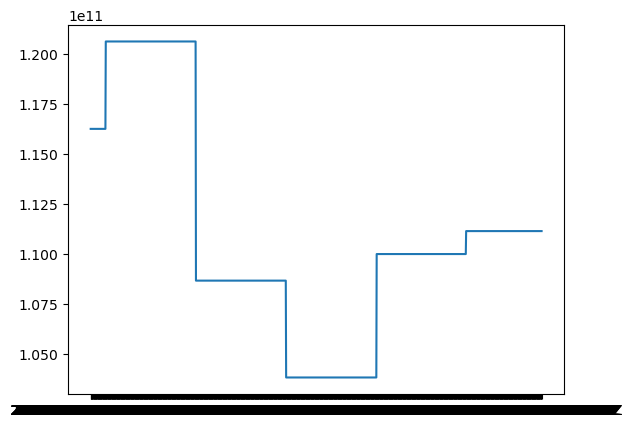

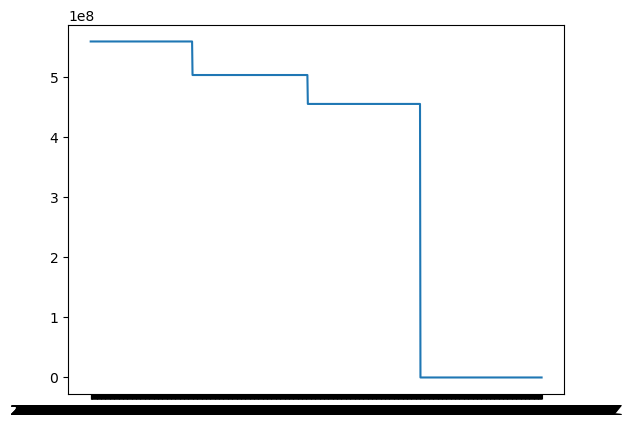

In [77]:
for ric in rics_list:
    plt.figure()

    equity = df_with_solutions.loc[ric]['Close Price'] * df_with_solutions.loc[ric]['Shares used to calculate Diluted EPS - Total']
    assets = df_with_solutions.loc[ric]['A_solution']

    plt.plot(assets-equity)
    plt.show()

## Computing the relevant quantities of the Merton's model

In [78]:
def compute_additional_metrics(row):
    # Extract inputs from the row
    V = row['A_solution']  # Asset value
    sigma = row['sigma_A_solution'] *252  # Asset volatility
    K = row['Debt - Total']  # Debt
    row['Risk_Free_Rate'] = 0.04
    r = row['Risk_Free_Rate']
    
    T = 1  # Time to maturity
    t = 0  # Current time

    # Compute quantities using the provided functions
    equity_value = af.merton_equity(V, K, r, sigma, T, t)
    debt_value = af.merton_debt(V, K, r, sigma, T, t)
    default_probability = af.risk_neutral_default_probability(V, K, r, sigma, T, t)
    credit_spread = af.credit_spread_model(V, K, sigma, r, T, t)

    # Return results as a Series
    return pd.Series({
        'Equity_Value': equity_value,
        'Debt_Value': debt_value,
        'Default_Probability': default_probability,
        'Credit_Spread': credit_spread
    })


In [79]:
# Compute additional metrics for each row
df_with_metrics = df_with_solutions.apply(compute_additional_metrics, axis=1)

# Combine results with the original DataFrame
df_final = pd.concat([df_with_solutions, df_with_metrics], axis=1)

c:\Users\franc\OneDrive\Synced Desktop\SF_project\codes\stochastic-finance-project\analytical_functions.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(V/K) + (r + 0.5*sigma**2)*(T-t))/ (sigma * np.sqrt(T-t))
c:\Users\franc\OneDrive\Synced Desktop\SF_project\codes\stochastic-finance-project\analytical_functions.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(V/K) + (r + 0.5*sigma**2)*(T-t))/ (sigma * np.sqrt(T-t))
c:\Users\franc\OneDrive\Synced Desktop\SF_project\codes\stochastic-finance-project\analytical_functions.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  d2 = (np.log(V / B) + (r - 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
c:\Users\franc\OneDrive\Synced Desktop\SF_project\codes\stochastic-finance-project\analytical_functions.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(V / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
c:\User

In [66]:
# View the final DataFrame
print(df_final.head())

                             Close Price  \
RIC    Date                                
META.O 2022-12-27T00:00:00Z       116.88   
       2022-12-23T00:00:00Z       118.04   
       2022-12-22T00:00:00Z       117.12   
       2022-12-21T00:00:00Z       119.76   
       2022-12-20T00:00:00Z       117.09   

                             Shares used to calculate Diluted EPS - Total  \
RIC    Date                                                                 
META.O 2022-12-27T00:00:00Z                                    2859000000   
       2022-12-23T00:00:00Z                                    2859000000   
       2022-12-22T00:00:00Z                                    2859000000   
       2022-12-21T00:00:00Z                                    2859000000   
       2022-12-20T00:00:00Z                                    2859000000   

                             Market Capitalization  Debt - Total  \
RIC    Date                                                        
META.O 2022-12-

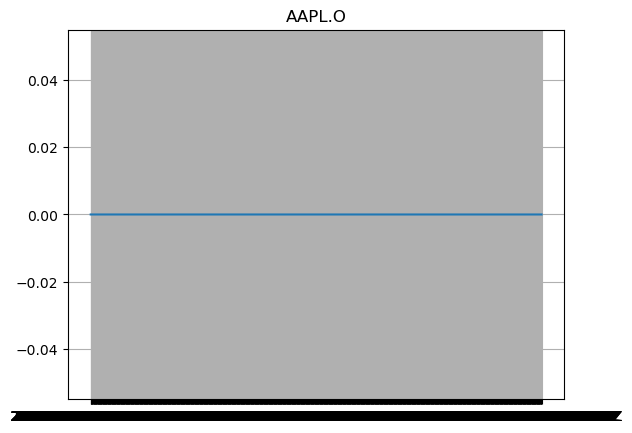

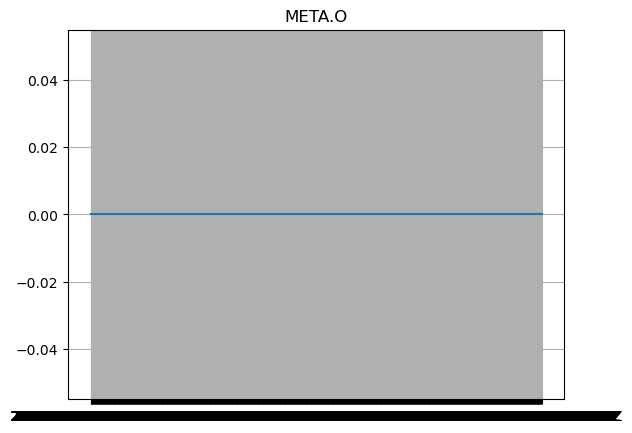

In [80]:
import matplotlib.pyplot as plt
for ric in rics_list:
    plt.figure()

    def_probab = df_final.loc[ric]['Default_Probability']
    plt.plot(def_probab)
    plt.title(f'{ric}')

    plt.grid()

    plt.show()

### Preparing the functions for the iterative procedure to compute asset values

In [118]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import root_scalar

def black_scholes_equation(V_t, S_t, B, r, T = 1, sigma_V = 0.1):
    """
    Compute the Black-Scholes equity price difference for an array of S_t, B, and r.
    This function is used to find the root for V_t.
    
    Parameters:
    V_t : float
        Asset value to solve for (scalar).
    S_t, B, r : np.array
        Arrays of equity prices, debt face values, and risk-free rates.
    T, sigma_V : float
        Constants: time to maturity and asset volatility.
    t : float
        Current time.

    Returns:
    np.array
        Difference between the calculated equity price and observed equity price S_t.
    """
    # Calculate d_t1 and d_t2 for all elements in S_t, B, and r
    
    d_t1 = (np.log(V_t / B) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
    d_t2 = d_t1 - sigma_V * np.sqrt(T)
    
    # Black-Scholes formula for equity price
    equity_price = V_t * norm.cdf(d_t1) - B * np.exp(-r * T) * norm.cdf(d_t2)
    
    # Return the difference from observed S_t
    return equity_price - S_t

def invert_black_scholes(S_t, B, r, T=1, sigma_V = 0.1, initial_guess=100):
    """
    Invert the Black-Scholes formula to estimate V_t for arrays of S_t, B, and r.
    
    Parameters:
    S_t, B, r : np.array
        Arrays of observed equity prices, debt face values, and risk-free rates.
    T, sigma_V : float
        Constants: time to maturity and asset volatility.
    t : float
        Current time.
    initial_guess : float
        Initial guess for V_t.

    Returns:
    np.array
        Estimated asset values (V_t) for each input set.
    """
    # Vectorized root finding for each element in S_t, B, and r
    V_t_estimates = []
    for S_t_i, B_i, r_i in zip(S_t, B, r):
        # Initial bracket
        a, b = 1, 400
        f_a = black_scholes_equation(a, S_t_i, B_i, r_i, T, sigma_V)
        f_b = black_scholes_equation(b, S_t_i, B_i, r_i, T, sigma_V)
        
        # Dynamically adjust the bracket until signs are opposite
        while f_a * f_b > 0:
            a /= 2
            b *= 2
            f_a = black_scholes_equation(a, S_t_i, B_i, r_i, T, sigma_V)
            f_b = black_scholes_equation(b, S_t_i, B_i, r_i, T, sigma_V)
        
        # Solve for V_t using root_scalar
        solution = root_scalar(
            black_scholes_equation,
            args=(S_t_i, B_i, r_i, T, sigma_V),
            bracket=[a, b],
            method='brentq'
        )
        V_t_estimates.append(solution.root)
    
    return np.array(V_t_estimates)
"""
# Example Usage
S_t = np.array([50e8, 60e8, 70e8])  # Observed equity prices
B = np.array([100e6, 120e6, 150e6])  # Face values of debt
r = np.array([0.05, 0.04, 0.03])  # Risk-free rates
T = 1.0  # Maturity in years (constant)
t = 0     # Current time
sigma_V = 0.2  # Asset volatility (constant)

V_t_estimated = invert_black_scholes(S_t, B, r, T, sigma_V)
print(f"Estimated Asset Values (V_t): {V_t_estimated}")
"""

'\n# Example Usage\nS_t = np.array([50e8, 60e8, 70e8])  # Observed equity prices\nB = np.array([100e6, 120e6, 150e6])  # Face values of debt\nr = np.array([0.05, 0.04, 0.03])  # Risk-free rates\nT = 1.0  # Maturity in years (constant)\nt = 0     # Current time\nsigma_V = 0.2  # Asset volatility (constant)\n\nV_t_estimated = invert_black_scholes(S_t, B, r, T, sigma_V)\nprint(f"Estimated Asset Values (V_t): {V_t_estimated}")\n'

In [119]:
instrument = 'AAPL.O'

prices = data.loc[instrument]['Close Price']
debt = data.loc[instrument]['Debt - Total'] / 10e9
r = [0.03] * prices.shape[0] 
r = np.array(r)
log_returns = np.log(prices / prices.shift(1)).dropna()
volatility_guess = log_returns.std()

#print(volatility_guess)
#print(prices)
equity_values = (data.loc[instrument]['Shares used to calculate Diluted EPS - Total'] * data.loc[instrument]['Close Price']) / 10e9

value_guess = invert_black_scholes(equity_values, debt, r, sigma_V=volatility_guess)
print(value_guess * 10e9)

[3.99026871e+12 4.04250216e+12 4.09535192e+12 ... 8.22065015e+11
 9.00716729e+11 8.99816710e+11]


In [111]:
equity_values

Date
2024-12-30T00:00:00Z    388.592156
2024-12-27T00:00:00Z      393.8155
2024-12-26T00:00:00Z    399.100477
2024-12-24T00:00:00Z    397.837013
2024-12-23T00:00:00Z    393.322441
                           ...    
2019-01-07T00:00:00Z     73.966612
2019-01-04T00:00:00Z     74.131616
2019-01-03T00:00:00Z      71.09655
2019-01-02T00:00:00Z     78.961721
2018-12-31T00:00:00Z     78.871719
Length: 1510, dtype: Float64

# Function calling

In [ ]:
"""
V = Total company value
K = Liability (strike price)
r = interest rate
sigma = standard deviation
T = Maturity
t = time (a volte non è nemmeno messo ho visto in alcune formule ma nel nostro libro c'è)


V = St+Bt

ST può essere vista come una call option ST = (VT-BT)+
BT come una Put option in pratica BT = B - (B-VT)+

"""

"""'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
FUNCTION TO COMPUTE THE EQUITY VALUE BASED ON MERTON
"""''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def merton_equity(V,K,r,sigma,T,t):

    d1 = (np.log(V/K) + (r + 0.5*sigma**2)*(T-t))/ (sigma * np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    St = V*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)

    return St

"""'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
FUNCTION TO COMPUTE THE DEBT VALUE BASED ON MERTON
"""''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def merton_debt(V,K,r,sigma,T,t):

    d1 = (np.log(V/K) + (r + 0.5*sigma**2)*(T-t))/ (sigma * np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    Bt = K*np.exp(-r*(T-t))*norm.cdf(d2) + V*(1-norm.cdf(d1))
    
    return Bt
#%% Inputs
r = 0.1        # Risk-free rate (10%)
sigma = 0.2    # Asset volatility (10%)
T = 1          # Maturity time (1 year)
t = 0          # Current time (0 years)

# Compute Equity and Debt
#equity_value = merton_equity(V, K, r, sigma, T, t)
#debt_value = merton_debt(V, K, r, sigma, T, t)

# Validation: Sum of Equity and Debt should equal Total Assets
#validation = equity_value + debt_value

# Output Results
#print(f"Equity Value (S) is: {equity_value:.6f}")
#print(f"Debt Value (B) is: {debt_value:.6f}")
#print(f"Difference between (S+B) and V: {validation:.6f} vs {V}")
#%%
data['Equity'] = data.apply(lambda row: merton_equity(row['Common Equity - Total'], row['Debt - Total'], r, sigma, T, t), axis=1)
data['Debt'] = data.apply(lambda row: merton_debt(row['Common Equity - Total'], row['Debt - Total'], r, sigma, T, t), axis=1)